<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week5/GRU_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GRU Model dengan PyTorch : ReviewTokoBaju.csv Dataset🦖**

GRU adalah pengembangan dari RNN yang dirancang untuk mengatasi masalah vanishing gradient. GRU menggunakan dua gerbang utama: gerbang pembaruan (update gate) dan gerbang reset (reset gate) untuk memutuskan informasi mana yang perlu disimpan dan mana yang harus dibuang.

In [19]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer


In [20]:
# Load dataset
file_path = '/content/ReviewTokoBaju.csv'
data = pd.read_csv(file_path)


## PreProcessing

In [21]:
# Pra-pemrosesan
data = data.dropna(subset=['Review Text', 'Recommended IND'])  # Menghapus baris dengan Review Text atau Recommended IND yang kosong
data['Review Text'] = data['Review Text'].apply(lambda x: x.lower())  # Mengubah teks menjadi lowercase


<ipython-input-21-45f67d9b05f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Review Text'] = data['Review Text'].apply(lambda x: x.lower())  # Mengubah teks menjadi lowercase


In [22]:
# Menyiapkan fitur (X) dan target (y)
X = data['Review Text']
y = data['Recommended IND']


In [23]:
# Tokenisasi menggunakan TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Membatasi hanya 5000 fitur teratas
X_tfidf = vectorizer.fit_transform(X).toarray()


In [24]:
# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [31]:
# Mengubah data menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Menambahkan dimensi sequence_length = 1
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)   # Menambahkan dimensi sequence_length = 1
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

## Build Model

In [26]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # GRU layer
        gru_out, _ = self.gru(x)
        # Hanya ambil output terakhir dari GRU
        last_hidden_state = gru_out[:, -1, :]
        output = self.fc(last_hidden_state)
        return output


In [27]:
# Definisikan model, loss, dan optimizer
input_dim = X_train_tensor.shape[1]  # Jumlah fitur (5000)
hidden_dim = 64  # Dimensi hidden state
output_dim = 2  # Dua kelas: direkomendasikan (1) atau tidak (0)
model = GRUModel(input_dim, hidden_dim, output_dim)


In [28]:
# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Model

In [29]:
num_epochs = 10  # Jumlah epoch
train_losses = []
train_accuracies = []


In [33]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Hitung akurasi
    _, predicted = torch.max(output, 1)
    correct = (predicted == y_train_tensor).sum().item()
    accuracy = correct / y_train_tensor.size(0)

    # Simpan nilai untuk visualisasi
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    if (epoch+1) % 2 == 0:  # Cetak setiap 2 epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")


Epoch [2/10], Loss: 0.5815, Accuracy: 0.8184
Epoch [4/10], Loss: 0.5679, Accuracy: 0.8184
Epoch [6/10], Loss: 0.5546, Accuracy: 0.8184
Epoch [8/10], Loss: 0.5416, Accuracy: 0.8184
Epoch [10/10], Loss: 0.5291, Accuracy: 0.8184


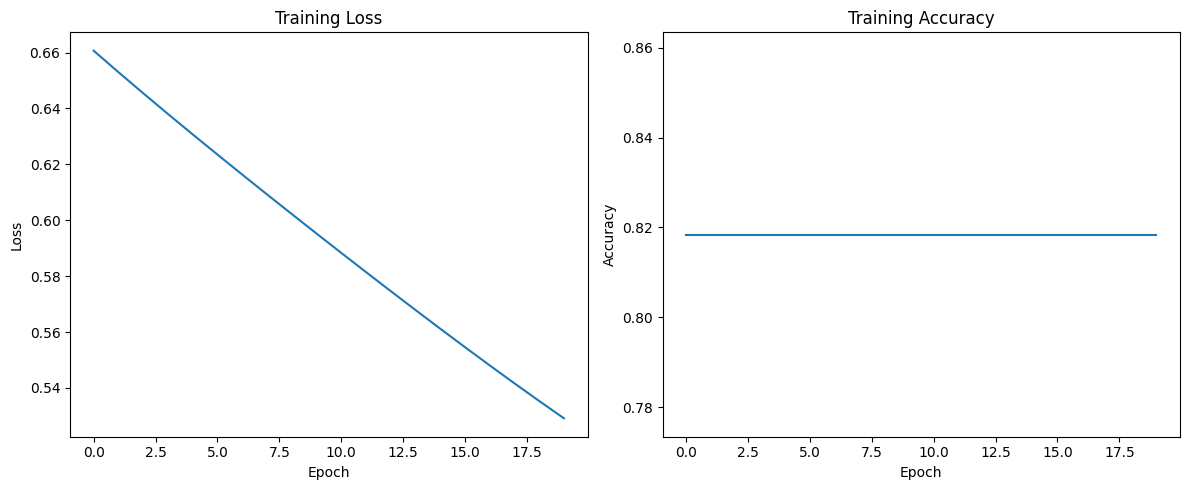

In [34]:
# Visualisasi Loss dan Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## Evaluasi Model

Accuracy: 0.8207
Precision: 0.8207
Recall: 1.0000
F1 Score: 0.9015
AUC: 0.5000


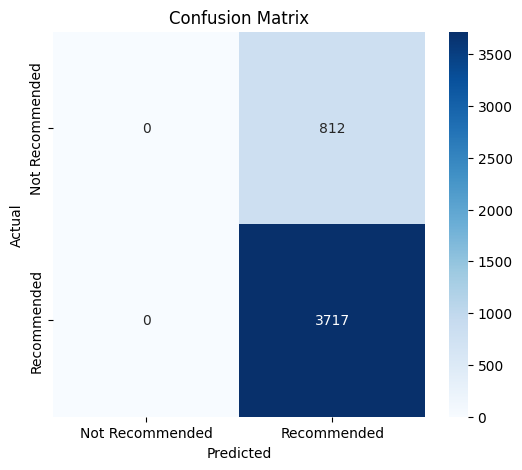

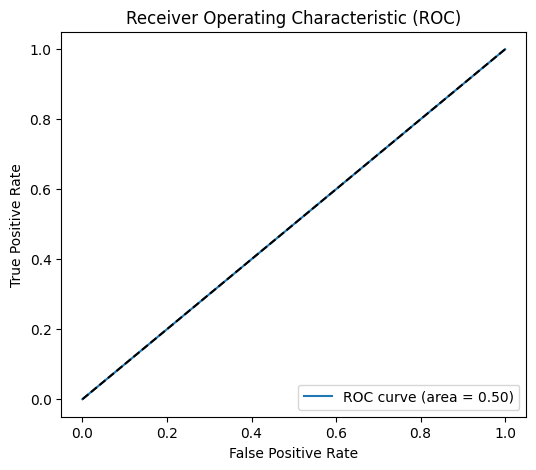

In [35]:
# Testing
model.eval()
with torch.no_grad():
    output_test = model(X_test_tensor)
    _, predicted_test = torch.max(output_test, 1)

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, predicted_test)
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    f1 = f1_score(y_test, predicted_test)
    auc = roc_auc_score(y_test, predicted_test)
    fpr, tpr, _ = roc_curve(y_test, predicted_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predicted_test)

    # Menampilkan hasil evaluasi
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'], yticklabels=['Not Recommended', 'Recommended'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

#**Penjelasan Singkat**

1️⃣ Akurasi (Accuracy)

Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi.


Akurasi=

*TP+TN/
TP+TN+FP+FN*
​

📌 Keterangan:

TP (True Positive) → Prediksi benar sebagai positif.

TN (True Negative) → Prediksi benar sebagai negatif.

FP (False Positive) → Prediksi salah sebagai positif.

FN (False Negative) → Prediksi salah sebagai negatif.


2️⃣ Presisi (Precision)

Presisi mengukur seberapa akurat model dalam memprediksi kelas positif.

Presisi=
*TP/
TP+FP*



📌 Keterangan:

Jika model memiliki presisi tinggi, berarti model jarang salah dalam memprediksi kelas positif.

Jika presisi rendah, model sering salah memprediksi negatif sebagai positif (False Positive tinggi).

3️⃣ Recall (Sensitivitas)

Recall mengukur seberapa baik model dalam menangkap semua kasus positif.

Recall=
*TP/
TP+FN*


📌 Keterangan:

Jika recall tinggi, berarti model berhasil menangkap hampir semua data positif.
Jika recall rendah, model sering gagal mengenali positif sebagai negatif (False Negative tinggi).

4️⃣ F1-Score (Harmonic Mean)
F1-score menggabungkan presisi dan recall dalam satu metrik menggunakan rata-rata harmonik.

𝐹
1
=
2
×
Presisi
×
Recall/
Presisi
+
Recall

📌 Keterangan:

F1-score tinggi berarti model seimbang dalam presisi dan recall.

Bagus untuk dataset tidak seimbang, karena mempertimbangkan False Positive dan False Negative secara bersamaan.

5️⃣ Area Under Curve (AUC - ROC)
AUC (Area Under Curve) mengukur seberapa baik model membedakan antara kelas positif dan negatif.

AUC berasal dari ROC Curve, yang membandingkan True Positive Rate (TPR) vs False Positive Rate (FPR).

TPR
=
𝑇
𝑃/
𝑇
𝑃
+
𝐹
𝑁

(Sama dengan Recall)

*FPR=
FP/
FP+TN*

📌 Keterangan:

AUC = 1.0 → Model sempurna (memisahkan kelas dengan sempurna).
AUC = 0.5 → Model acak (tidak lebih baik dari tebak-tebakan).
AUC < 0.5 → Model lebih buruk dari acak (terbalik).

6️⃣ Receiver Operating Characteristic (ROC) Curve

ROC Curve adalah grafik yang membandingkan TPR vs FPR pada berbagai threshold.


Sumbu X → FPR (False Positive Rate)

Sumbu Y → TPR (True Positive Rate / Recall)

📌 Bagaimana membacanya?


Semakin tinggi kurva, semakin baik model.

ROC yang mendekati diagonal (AUC ≈ 0.5) berarti model tidak berguna.